# InvoiceNet
I used the processed version of the tokens from the 'group' column strored in the 'type' column of the dataframe for classification. I generate the vocabulary and the corresponding word vectors for the vocabulary using the word2vec model. Using these word embeddings, each token in the input data is converted into a word vector and these word vectors are joined together to produce a matrix-like version of the input data entity where each slice of the matrix represents the word vector for each word in the input data.

A convolution neural network is used to extract information from the word embeddings. A fully-connected layer is connected to the output of the convolution layers. The midpoint information for the data entitiy is concatonated to the output of the last fully-connected layer. A final fully-connected layer is used to produce the class prediction. Dropout is used in the fully-connected layers to prevent overfitting.

In [1]:
import numpy as np
import pickle
import gzip
from gensim.models import Word2Vec
# Dependencies for the DataHandler Class

# DataHandler
DataHandler class takes in a pandas dataframe as input and provides functions to process and prepare the data for training

In [2]:
class DataHandler:
    def __init__(self, data=None, max_len=10):
        self.data = data
        self.max_length = max_len
        self.vocab_size = 0
        self.word2idx = {}
        self.idx2word = {}
        self.embeddings = None
        self.embed_size = 300
        self.PAD = '<pad>'
        self.UNKNOWN = '<unk>'
        self.START = '<start>'
        self.END = '<end>'
        self.label_dict = {0: 0, 1: 1, 2: 2, 8: 3, 14: 4, 18: 5}
        self.num_classes = len(self.label_dict)
        self.train_data = {}
        # self.type_dict = {'text': 0.1, 'number': 0.2, 'email': 0.3, 'date': 0.4, '': 0.5, 'money': 0.6, 'phone': 0.7}

    def read(self, data, max_len=10):
        """Read DataFrame"""
        self.data = data
        self.max_length = max_len

    def process_data(self, tokens, coordinates):
        tokens = [self.START] + tokens[:self.max_length - 2] + [self.END]
        tokens += [self.PAD] * (self.max_length - len(tokens))
        inp = np.array([self.get_word_id(token) for token in tokens])
        coordinates = np.array(coordinates)
        return inp, coordinates

    def prepare_data(self):
        """Prepares data for training"""
        inputs = []
        labels = []
        coordinates = []

        for i, row in self.data.iterrows():
            text = row['type']
            coords = row['coords']
            label = self.label_dict[int(row['label'])]
            tokens = text[0].strip().split(' ')
            # dtypes = [self.type_dict[dtype] for dtype in text[1].split(',')]
            height = float(text[-2])
            width = float(text[-1])
            min_x = float(coords[0]) / width
            min_y = float(coords[1]) / height
            max_x = float(coords[2]) / width
            max_y = float(coords[3]) / height

            tokens = [self.START] + tokens[:self.max_length - 2] + [self.END]
            tokens += [self.PAD] * (self.max_length - len(tokens))
            inp = [self.get_word_id(token) for token in tokens]

            inputs.append(np.array(inp))
            labels.append(np.array(label))
            coordinates.append(np.array([min_x, min_y, max_x, max_y]))

        self.train_data['inputs'] = np.array(inputs)
        self.train_data['labels'] = np.array(labels)
        self.train_data['coordinates'] = np.array(coordinates)

    def load_embeddings(self, model_path):
        """Loads pre-trained gensim model"""
        print("\nLoading pre-trained embeddings...")

        model = Word2Vec.load(model_path)
        words = list(model.wv.vocab)
        embed_size = model.layer1_size

        embed = []
        word2idx = {self.PAD: 0, self.UNKNOWN: 1, self.START: 2, self.END: 3}
        idx2word = {0: self.PAD, 1: self.UNKNOWN, 2: self.START, 3: self.END}

        embed.append(np.zeros(embed_size, dtype=np.float32))
        embed.append(np.random.uniform(-0.1, 0.1, embed_size))
        embed.append(np.random.uniform(-0.1, 0.1, embed_size))
        embed.append(np.random.uniform(-0.1, 0.1, embed_size))

        for word in words:
            vector = model.wv[word]
            embed.append(vector)
            word2idx[word] = len(word2idx)
            idx2word[word2idx[word]] = word

        self.vocab_size = len(word2idx)
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.embeddings = np.array(embed, dtype=np.float32)

        print("\nSuccessfully loaded pre-trained embeddings!")

    def get_word_id(self, token):
        """Returns the id of a token"""
        token = token.lower()
        if token in self.word2idx:
            return self.word2idx[token]
        return self.word2idx[self.UNKNOWN]

    def save_data(self, out_path='./data/processed.pkl.gz'):
        """Saves the embeddings and vocab as a zipped pickle file"""
        assert (self.embeddings is not None or self.word2idx), "Data has not been processed yet"
        pkl = {'embeddings': self.embeddings,
               'word2idx': self.word2idx,
               'idx2word': self.idx2word
               }
        with gzip.open(out_path, 'wb') as out_file:
            pickle.dump(pkl, out_file)
        print("\nData stored as {}".format(out_path))

    def load_data(self, path):
        """Loads embeddings and vocab from a zipped pickle file"""
        with gzip.open(path, 'rb') as in_file:
            pkl = pickle.load(in_file)
        self.embeddings = pkl['embeddings']
        self.embed_size = self.embeddings.shape[1]
        self.word2idx = pkl['word2idx']
        self.vocab_size = len(self.word2idx)
        self.idx2word = pkl['idx2word']
        print("\nSuccessfully loaded data from {}".format(path))


# Gensim - Word2Vec
We use gensim word2vec implementation to train vector embeddings for our vocabulary

In [3]:
%matplotlib inline
import pickle
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Dependencies for word2vec

Word2Vec(vocab=689, size=300, alpha=0.025)


/home/naivehobo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


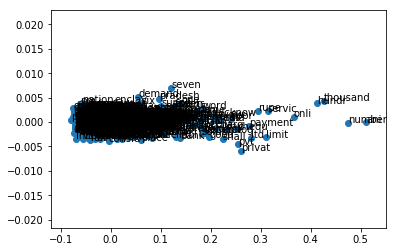

In [4]:
with open('train_api.pk', 'rb') as pklfile:
    df = pickle.load(pklfile)

sentences = []

# Iterate through all the rows of the dataframe and split each processed 
for i, row in df.iterrows():
    text = row['type'][0].strip()
    sentences.append(text.split(' '))

model = Word2Vec(sentences, size=300, window=5, min_count=3, workers=4)
model.save('model.bin')
print(model)

X = model[model.wv.vocab]

pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.scatter(result[:, 0], result[:, 1])

words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

# InvoiceNet - Model
The InvoiceNet class builds the model architecture and provides utility functions to train the model, perform inference on a trained model and load saved weights.

In [5]:
import numpy as np
import os
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.layers import Embedding
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
# Dependencies for InvoiceNet class

# Setting random seed
np.random.seed(1337)

Using TensorFlow backend.


In [6]:
class InvoiceNet:

    def __init__(self, data_handler, config):
        coordinates = Input(shape=(data_handler.train_data['coordinates'].shape[1],), dtype='float32', name='coordinates')
        words_input = Input(shape=(data_handler.max_length,), dtype='int32', name='words_input')
        words = Embedding(data_handler.embeddings.shape[0], data_handler.embeddings.shape[1],
                          weights=[data_handler.embeddings],
                          trainable=False)(words_input)

        conv1 = Convolution1D(filters=config.num_filters,
                              kernel_size=3,
                              padding='same',
                              activation='relu',
                              strides=1,
                              kernel_regularizer=regularizers.l2(config.reg_rate))(words)
        pool1 = GlobalMaxPooling1D()(conv1)

        conv2 = Convolution1D(filters=config.num_filters,
                              kernel_size=4,
                              padding='same',
                              activation='relu',
                              strides=1,
                              kernel_regularizer=regularizers.l2(config.reg_rate))(words)
        pool2 = GlobalMaxPooling1D()(conv2)

        conv3 = Convolution1D(filters=config.num_filters,
                              kernel_size=5,
                              padding='same',
                              activation='relu',
                              strides=1,
                              kernel_regularizer=regularizers.l2(config.reg_rate))(words)
        pool3 = GlobalMaxPooling1D()(conv3)

        output = concatenate([pool1, pool2, pool3])
        output = Dropout(0.5)(output)
        output = concatenate([output, coordinates])
        output = Dense(config.num_hidden, activation='relu')(output)
        output = Dropout(0.5)(output)
        output = Dense(data_handler.num_classes, activation='softmax')(output)

        self.model = Model(inputs=[words_input, coordinates], outputs=[output])
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
        # self.model.summary()
        self.data_handler = data_handler
        self.config = config

    def train(self):
        print("\nInitializing training...")

        if not os.path.exists(self.config.log_dir):
            os.makedirs(self.config.log_dir)

        if not os.path.exists(self.config.checkpoint_dir):
            os.makedirs(self.config.checkpoint_dir)

        if not os.path.exists(self.config.model_path):
            os.makedirs(self.config.model_path)

        tensorboard = keras.callbacks.TensorBoard(log_dir=self.config.log_dir, histogram_freq=1, write_graph=True)
        modelcheckpoints = keras.callbacks.ModelCheckpoint(os.path.join(self.config.checkpoint_dir, "InvoiceNet_") +
                                                           ".{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.hdf5",
                                                           monitor='val_loss', verbose=0, save_best_only=True,
                                                           save_weights_only=False, mode='auto')

        class_weights = compute_class_weight('balanced', np.unique(self.data_handler.train_data['labels']), self.data_handler.train_data['labels'])
        d_class_weights = dict(enumerate(class_weights))

        self.model.fit([self.data_handler.train_data['inputs'], self.data_handler.train_data['coordinates']],
                       self.data_handler.train_data['labels'],
                       batch_size=self.config.batch_size,
                       verbose=True,
                       epochs=self.config.num_epochs,
                       callbacks=[tensorboard, modelcheckpoints],
                       validation_split=0.125,
                       shuffle=self.config.shuffle,
                       class_weight=d_class_weights)

        self.model.save_weights(os.path.join(self.config.model_path, "InvoiceNet.model"))

    def load_weights(self, path):
        """Loads weights from the given model file"""
        self.model.load_weights(path)
        print("\nSuccessfully loaded weights from {}".format(path))

    def predict(self, tokens, coordinates):
        """Performs inference on the given tokens and coordinates"""
        inp, coords = self.data_handler.process_data(tokens, coordinates)
        pred = self.model.predict([inp, coords], verbose=True)
        pred = pred.argmax(axis=-1)
        return pred

    def evaluate(self):
        predictions = self.model.predict([self.data_handler.train_data['inputs'], self.data_handler.train_data['coordinates']], verbose=True)
        predictions = predictions.argmax(axis=-1)
        acc = np.sum(predictions == self.data_handler.train_data['labels']) / float(len(self.data_handler.train_data['labels']))
        print("\nTest Accuracy: {}".format(acc))
        return predictions

    @staticmethod
    def get_precision(predictions, true_labels, target_label):
        target_label_count = 0
        correct_target_label_count = 0

        for idx in xrange(len(predictions)):
            if predictions[idx] == target_label:
                target_label_count += 1
                if predictions[idx] == true_labels[idx]:
                    correct_target_label_count += 1

        if correct_target_label_count == 0:
            return 0
        return float(correct_target_label_count) / target_label_count

    def f1_score(self, predictions):
        f1_sum = 0
        f1_count = 0
        for target_label in xrange(0, max(self.data_handler.train_data['labels'])):
            precision = self.get_precision(predictions, self.data_handler.train_data['labels'], target_label)
            recall = self.get_precision(self.data_handler.train_data['labels'], predictions, target_label)
            f1 = 0 if (precision+recall) == 0 else 2*precision*recall/(precision+recall)
            f1_sum += f1
            f1_count += 1

        macrof1 = f1_sum / float(f1_count)
        print("\nMacro-Averaged F1: %.4f\n" % macrof1)
        return macrof1

# Config
Config class to define training/testing parameters. Change mode to 'test' to run the model on the test data.

In [7]:
class Config:
    def __init__(self, data):
        self.data = data                                # path to training or testing data
        self.word2vec = "model.bin"                     # path to trained word2vec model
        self.model_path = "./model"                     # path to directory where trained model should be stored
        self.load_weights = "./model/InvoiceNet.model"  # path to saved weights file
        self.checkpoint_dir = "./checkpoints"           # path to directory where checkpoints should be stored
        self.log_dir = "./logs"                         # path to directory where tensorboard logs should be stored
        self.num_epochs = 200                           # number of epochs
        self.num_hidden = 512                           # size of hidden layer
        self.num_filters = 100                          # number of filters
        self.batch_size = 64                            # size of mini-batch
        self.reg_rate = 0.0001                          # rate of regularization
        self.shuffle = True                             # shuffle dataset

# Training

In [8]:
# Training the network on the data

# Defining a DataHandler object and preparing data for training
config = Config(data="train_api.pk")

with open(config.data, 'rb') as pklfile:
    df = pickle.load(pklfile)

data = DataHandler(df, max_len=12)
data.load_embeddings(config.word2vec)
data.prepare_data()

print(data.train_data['inputs'].shape)
print(data.train_data['labels'].shape)
print(data.train_data['coordinates'].shape)

net = InvoiceNet(data_handler=data, config=config)
net.train()


Loading pre-trained embeddings...

Successfully loaded pre-trained embeddings!


/home/naivehobo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).


(4754, 12)
(4754,)
(4754, 4)

Initializing training...
Train on 4159 samples, validate on 595 samples
Epoch 1/200
4159/4159 [==============================] - 2s 548us/step - loss: 1.8490 - acc: 0.3460 - val_loss: 1.2869 - val_acc: 0.0353
Epoch 2/200
4159/4159 [==============================] - 1s 235us/step - loss: 1.6811 - acc: 0.1897 - val_loss: 1.2626 - val_acc: 0.0286
Epoch 3/200
4159/4159 [==============================] - 1s 235us/step - loss: 1.5829 - acc: 0.1885 - val_loss: 1.1617 - val_acc: 0.2605
Epoch 4/200
4159/4159 [==============================] - 1s 235us/step - loss: 1.5316 - acc: 0.2101 - val_loss: 1.0761 - val_acc: 0.1983
Epoch 5/200
4159/4159 [==============================] - 1s 236us/step - loss: 1.4924 - acc: 0.2390 - val_loss: 1.1522 - val_acc: 0.2739
Epoch 6/200
4159/4159 [==============================] - 1s 236us/step - loss: 1.3861 - acc: 0.2941 - val_loss: 1.0306 - val_acc: 0.2840
Epoch 7/200
4159/4159 [==============================] - 1s 249us/step - los

Epoch 60/200
4159/4159 [==============================] - 1s 230us/step - loss: 0.7441 - acc: 0.4970 - val_loss: 0.6063 - val_acc: 0.4992
Epoch 61/200
4159/4159 [==============================] - 1s 231us/step - loss: 0.7474 - acc: 0.4958 - val_loss: 0.6270 - val_acc: 0.5832
Epoch 62/200
4159/4159 [==============================] - 1s 229us/step - loss: 0.7631 - acc: 0.5170 - val_loss: 0.6088 - val_acc: 0.5378
Epoch 63/200
4159/4159 [==============================] - 1s 230us/step - loss: 0.7382 - acc: 0.5078 - val_loss: 0.6447 - val_acc: 0.5529
Epoch 64/200
4159/4159 [==============================] - 1s 230us/step - loss: 0.7747 - acc: 0.5071 - val_loss: 0.6455 - val_acc: 0.5059
Epoch 65/200
4159/4159 [==============================] - 1s 230us/step - loss: 0.7803 - acc: 0.5013 - val_loss: 0.6868 - val_acc: 0.5445
Epoch 66/200
4159/4159 [==============================] - 1s 230us/step - loss: 0.7697 - acc: 0.5083 - val_loss: 0.6206 - val_acc: 0.4571
Epoch 67/200
4159/4159 [==========

4159/4159 [==============================] - 1s 231us/step - loss: 0.6947 - acc: 0.5396 - val_loss: 0.5956 - val_acc: 0.5580
Epoch 120/200
4159/4159 [==============================] - 1s 229us/step - loss: 0.7047 - acc: 0.5227 - val_loss: 0.5115 - val_acc: 0.5412
Epoch 121/200
4159/4159 [==============================] - 1s 231us/step - loss: 0.6401 - acc: 0.5107 - val_loss: 0.6222 - val_acc: 0.5916
Epoch 122/200
4159/4159 [==============================] - 1s 229us/step - loss: 0.6126 - acc: 0.5549 - val_loss: 0.6241 - val_acc: 0.5782
Epoch 123/200
4159/4159 [==============================] - 1s 231us/step - loss: 0.6099 - acc: 0.5535 - val_loss: 0.7451 - val_acc: 0.5664
Epoch 124/200
4159/4159 [==============================] - 1s 231us/step - loss: 0.6756 - acc: 0.5396 - val_loss: 0.5701 - val_acc: 0.5563
Epoch 125/200
4159/4159 [==============================] - 1s 231us/step - loss: 0.7220 - acc: 0.5107 - val_loss: 0.5964 - val_acc: 0.5765
Epoch 126/200
4159/4159 [================

Epoch 178/200
4159/4159 [==============================] - 1s 244us/step - loss: 0.5705 - acc: 0.5754 - val_loss: 0.5784 - val_acc: 0.5479
Epoch 179/200
4159/4159 [==============================] - 1s 240us/step - loss: 0.6394 - acc: 0.5694 - val_loss: 0.5972 - val_acc: 0.5008
Epoch 180/200
4159/4159 [==============================] - 1s 240us/step - loss: 0.6159 - acc: 0.5258 - val_loss: 0.5899 - val_acc: 0.5899
Epoch 181/200
4159/4159 [==============================] - 1s 242us/step - loss: 0.5762 - acc: 0.5607 - val_loss: 0.5436 - val_acc: 0.5092
Epoch 182/200
4159/4159 [==============================] - 1s 252us/step - loss: 0.5783 - acc: 0.5434 - val_loss: 0.5879 - val_acc: 0.5697
Epoch 183/200
4159/4159 [==============================] - 1s 250us/step - loss: 0.5786 - acc: 0.5696 - val_loss: 0.6170 - val_acc: 0.5849
Epoch 184/200
4159/4159 [==============================] - 1s 245us/step - loss: 0.6679 - acc: 0.5682 - val_loss: 0.6069 - val_acc: 0.5714
Epoch 185/200
4159/4159 [==

# Inference
Runs the model on the test data and calculates the test accuracy and f1 score.

In [9]:
label_dict = {0: "Other",
              1: "Invoice Date",
              2: "Invoice Number",
              3: "Buyer GST",
              4: "Seller GST",
              5: "Total Amount"}

config = Config(data="test_api.pk")

with open(config.data, 'rb') as pklfile:
    df = pickle.load(pklfile)

data = DataHandler(df, max_len=12)
data.load_embeddings(config.word2vec)
data.prepare_data()

print(data.train_data['inputs'].shape)
print(data.train_data['labels'].shape)
print(data.train_data['coordinates'].shape)

net = InvoiceNet(data_handler=data, config=config)

net.load_weights(config.load_weights)
predictions = net.evaluate()
net.f1_score(predictions)


Loading pre-trained embeddings...

Successfully loaded pre-trained embeddings!
(1023, 12)
(1023,)
(1023, 4)


/home/naivehobo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).



Successfully loaded weights from ./model/InvoiceNet.model
1023/1023 [==============================] - 0s 168us/step

Test Accuracy: 0.55522971652

Macro-Averaged F1: 0.3681



0.3680815763419294